In [45]:
import pandas as pd
import seaborn as sns
import textwrap
import matplotlib.pyplot as plt
import string
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk import ngrams
from collections import Counter
nltk.download('punkt')
nltk.download('punkt_tab')
import numpy as np
from scipy import stats


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [35]:
from google.colab import drive
drive.mount('/content/drive')
file_1= '/content/drive/MyDrive/DSC 672/Original Data/Description and Outcome ID.xlsx'
file_2= '/content/drive/MyDrive/DSC 672/Original Data/Validated Data from Heather.xlsx'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
desc_outcome= pd.read_excel(file_1)
val_data= pd.read_excel(file_2)
#desc_outcome.head(n=2)
val_data.head(n=5)


,programreportid,programdescription,impactarea,genome,outcome,outcomeid
0,1000,The Cultural Allianceâ€™s work falls into two ...,Arts,Creative Community,Strengthened Creative Community,199.0
1,1004,The Unity Performing Arts programming is focus...,Youth,Youth Development,Social and Emotional Skills,190.0
2,1029,ChiS&E provides a rigorous 4 week summer en...,Education,STEM,STEM Proficiency,196.0
3,1010,CodePath.org offers a three-part program that ...,Education,STEM,STEM Persistence,195.0
4,1061,"The Baltimore Educational Scholarship Trust, i...",Education,College and Career Readiness,High School Completion,89.0


In [ ]:
print(val_data['impactarea'].value_counts())

impactarea
Education                         1437
Economic Development              1205
Public Health                     1100
Critical Human Needs              1001
Youth                              519
Systems Change                     393
Arts                               336
Global Development                 166
Sustainability and Environment     132
Culture and Identity                79
Science and Technology              62
Criminal Justice                    19
Name: count, dtype: int64


In [ ]:
print(val_data['genome'].value_counts())

genome
Healthcare Access and Advocacy              699
Workforce Development                       609
College and Career Readiness                566
Youth Development                           519
Food Security                               489
K-12 Student Achievement                    336
Financial Health                            331
STEM                                        270
Capacity Building                           230
Access and Appreciation                     228
Intimate Partner Health                     207
Business Development                        201
Housing and Homelessness                    194
Quality of Education                        152
Mental and Behavioral Health                135
Homelessness                                124
Early Childhood Education                   113
Policy Development                          111
Creative Community                          108
Disaster Preparedness and Relief             91
Housing                          

In [ ]:
print("# Unique values in columns")
for col in val_data.columns:
    print(f"{col}: {val_data[col].nunique()}")

print("\n# Entries in columns")
for col in val_data.columns:
    print(f"{col}: {val_data[col].count()}")

# Unique values in columns
programreportid: 6649
programdescription: 3699
impactarea: 12
genome: 50
outcome: 201
outcomeid: 289

# Entries in columns
programreportid: 6649
programdescription: 6642
impactarea: 6449
genome: 6449
outcome: 6449
outcomeid: 6449


<ipython-input-50-9f33c9dfb200>:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=80)


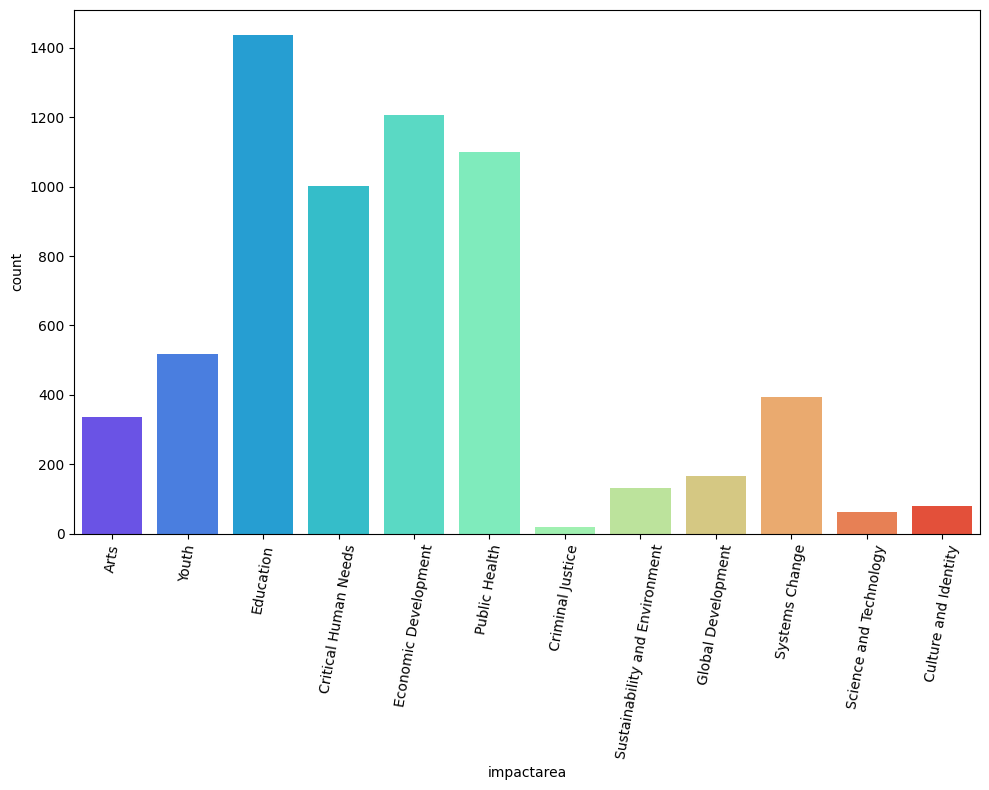

In [50]:
plt.rcParams["figure.figsize"]=[10, 8]
plt.rcParams["figure.autolayout"]=True
ax=sns.countplot(x='impactarea', data=val_data, hue='impactarea', legend=False, palette='rainbow')

labels=ax.get_xticklabels()
ax.set_xticklabels(labels, rotation=80)
plt.show()

In [ ]:
prog_desc= val_data['programdescription'].dropna()
wcts= np.array([len(nltk.word_tokenize(desc)) for desc in prog_desc])

mean_wcts= np.mean(wcts)
median_wcts= np.median(wcts)

print(f"Mean word count: {mean_wcts}")
print(f"Median word count: {median_wcts}")

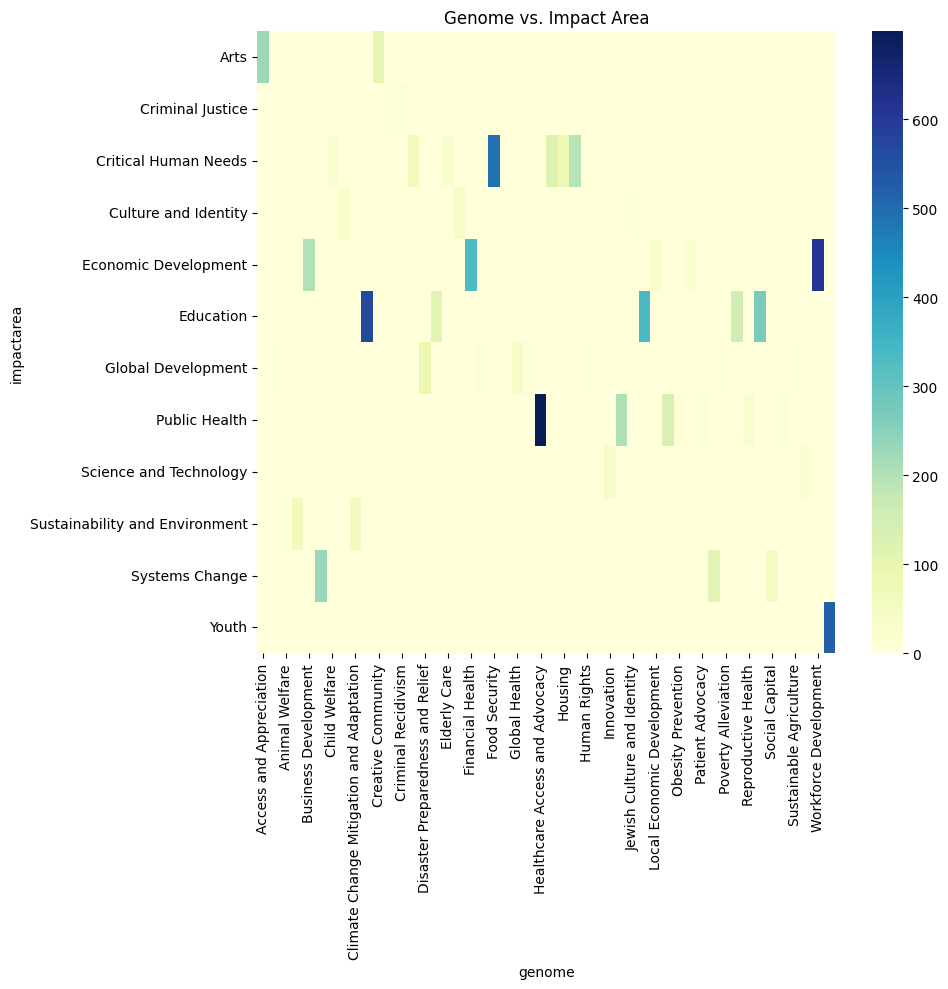

In [51]:
pivot_table= val_data.pivot_table(index='impactarea', columns='genome', aggfunc='size', fill_value=0)
plt.figure(figsize=(10,10))
sns.heatmap(pivot_table,cmap="YlGnBu", annot=False)
plt.title("Genome vs. Impact Area")
plt.tight_layout()
plt.show()


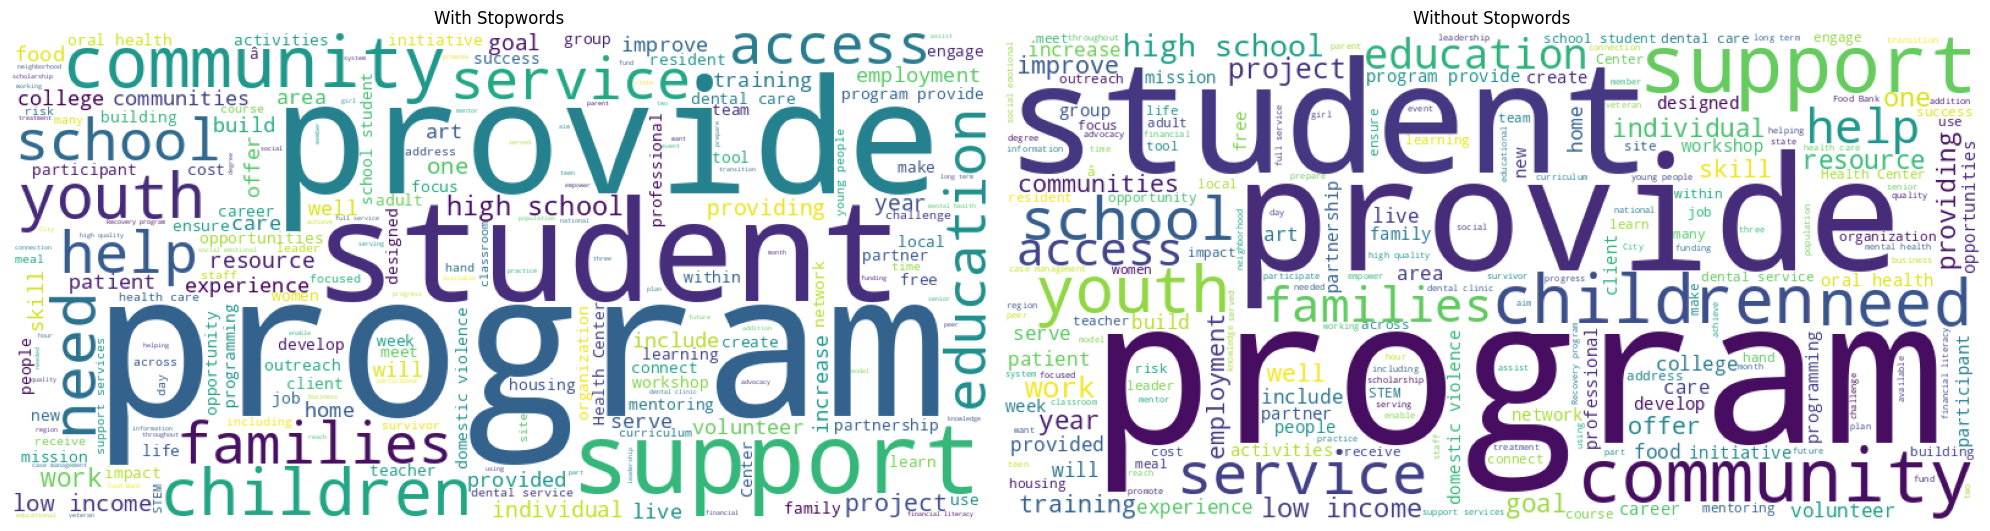

In [52]:
#take program descs into 1 string
text=" ".join(description for description in val_data['programdescription'].dropna())

#make wc with and without stopwords to compare
wc_stopwords= WordCloud(stopwords=STOPWORDS, background_color="white", width=800, height=400).generate(text)
wc_no_stopwords= WordCloud(background_color="white", width=800, height=400).generate(text)

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(wc_stopwords)
plt.title("With Stopwords")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(wc_no_stopwords)
plt.title("Without Stopwords")
plt.axis("off")
plt.show()

In [44]:
impact_areas= val_data['impactarea'].unique()

#remove impact areas with no descriptions
filtered_impact_areas=[]
for impact_area in impact_areas:
    descriptions=val_data[val_data['impactarea'] == impact_area]['programdescription'].dropna()
    if not descriptions.empty:
        filtered_impact_areas.append(impact_area)

plt.figure(figsize=(20, 20))
for i, impact_area in enumerate(filtered_impact_areas, 1):
    prog_desc = val_data[val_data['impactarea'] == impact_area]['programdescription'].dropna()
    text= " ".join(prog_desc) #take program descs into 1 string
    wc= WordCloud(stopwords=STOPWORDS, background_color="white", width=800, height=400).generate(text)
    plt.subplot(4, 3, i)
    plt.imshow(wc)
    plt.title(impact_area)
    plt.axis("off")
plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

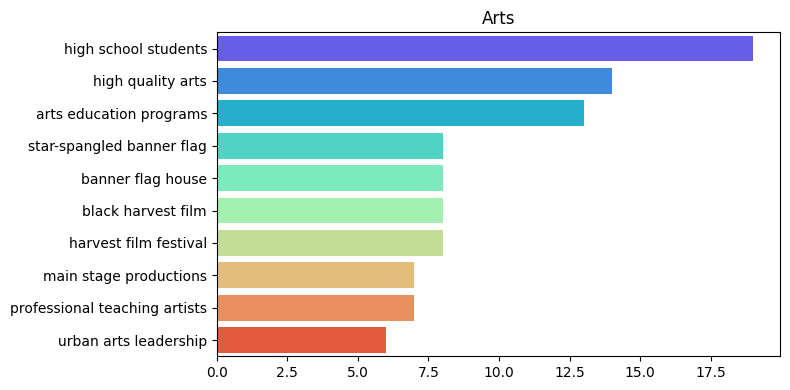

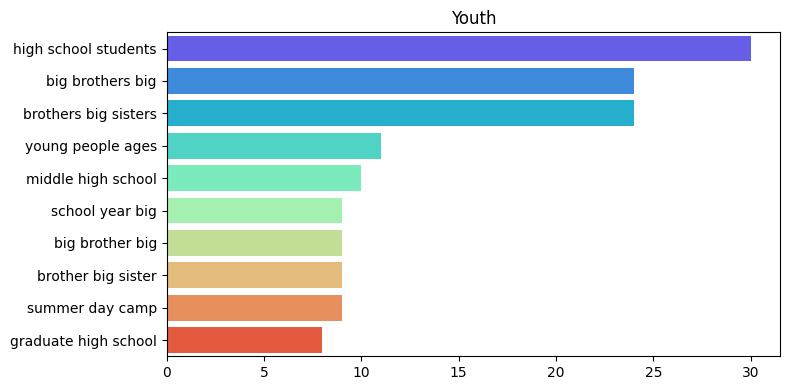

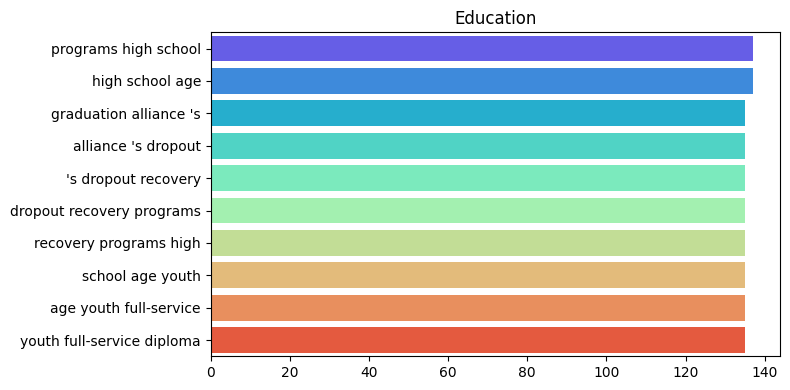

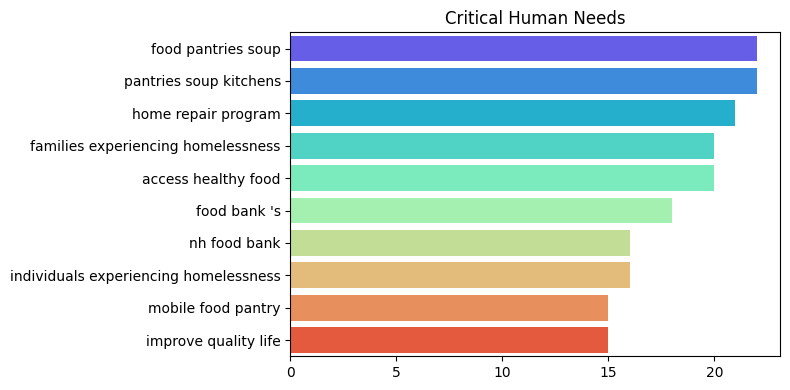

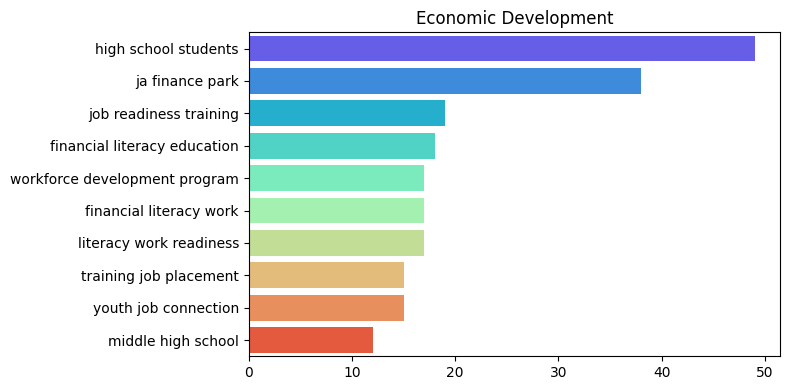

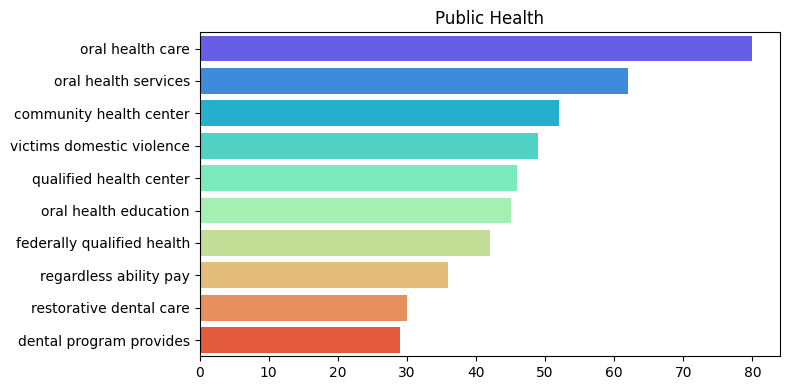

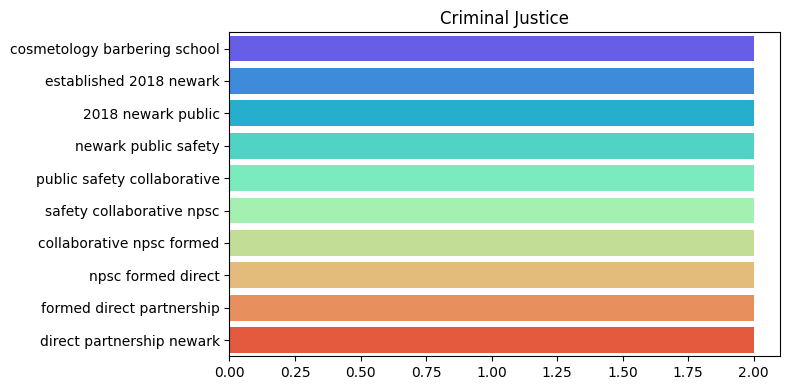

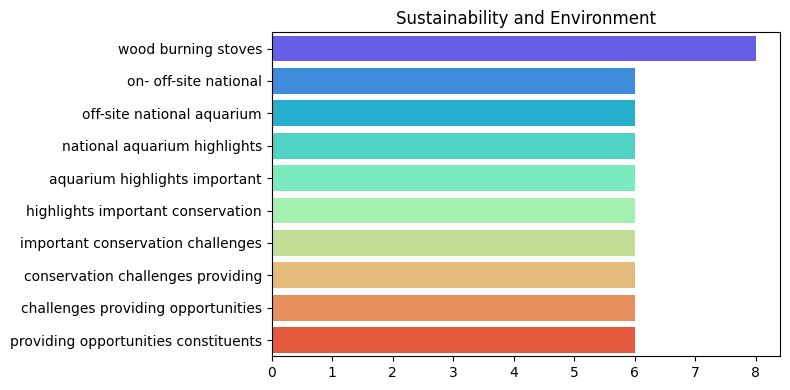

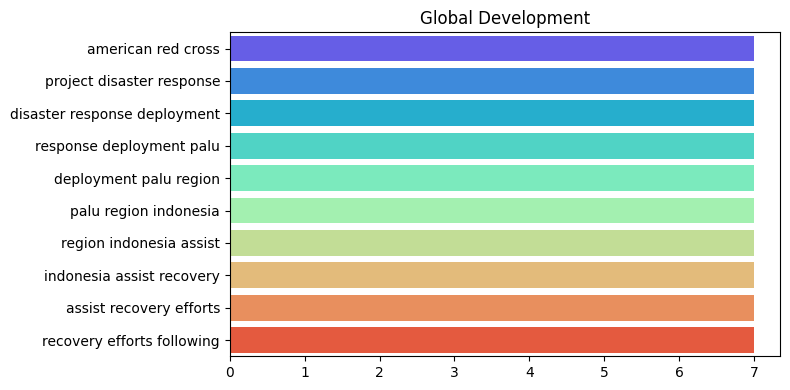

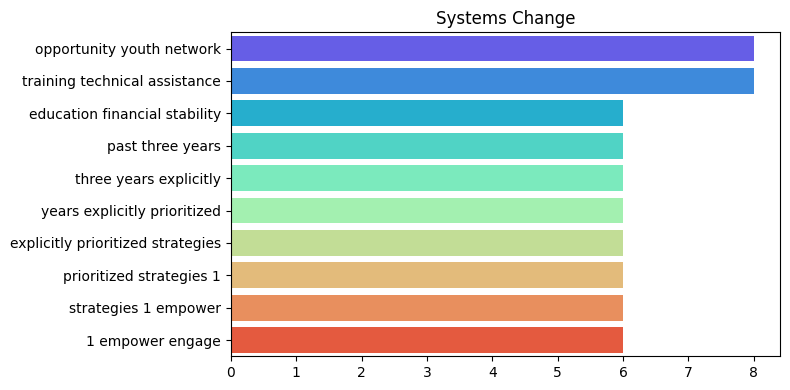

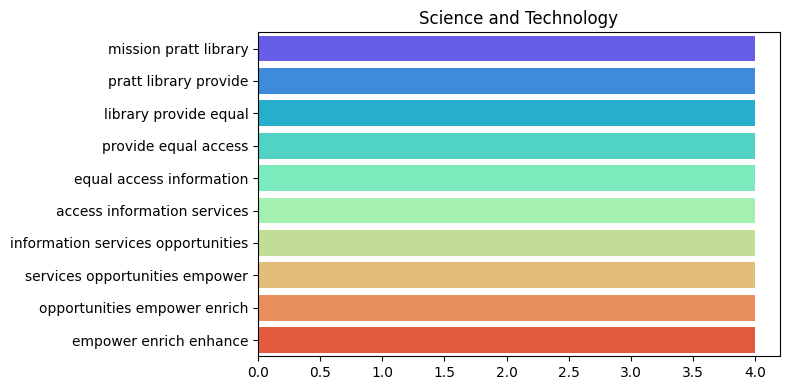

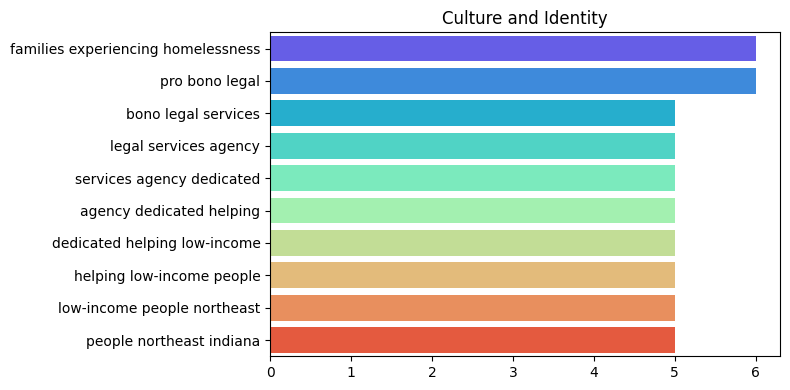

In [40]:
def gen_ngrams(tokens_list, n):
    ngrams_list=ngrams(tokens_list,n)
    ngrams_counts=Counter(ngrams_list)
    return ngrams_counts

#show top 10 trigrams for each impact area
for impact_area in filtered_impact_areas:
    trigram_counts=Counter() #set counter
    #get program descriptions
    prog_desc=val_data[val_data['impactarea']==impact_area]['programdescription'].dropna()
    text= " ".join(prog_desc) #take program descs into 1 string
    #clean text
    tokens= nltk.word_tokenize(text)
    tokens= [token.lower() for token in tokens if token.lower() not in STOPWORDS and token not in string.punctuation]

    trigram_counts.update(gen_ngrams(tokens, 3)) #update counts
    most_common_trigrams= trigram_counts.most_common(10) #get most common

    plt.figure(figsize=(8, 4))
    sns.barplot(x=[count for trigram, count in most_common_trigrams],
                y=[' '.join(trigram) for trigram, count in most_common_trigrams],
                hue=[' '.join(trigram) for trigram, count in most_common_trigrams], legend=False,
                palette='rainbow')
    plt.title(impact_area)
    plt.tight_layout()
    plt.show()